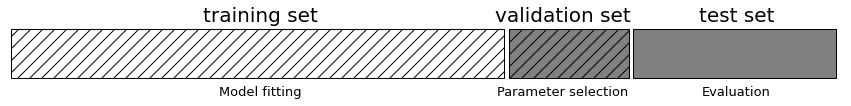

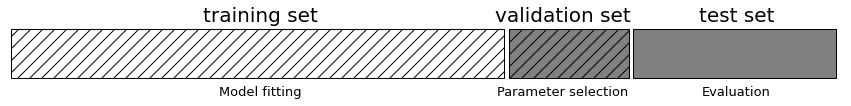

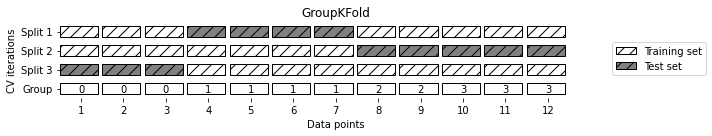

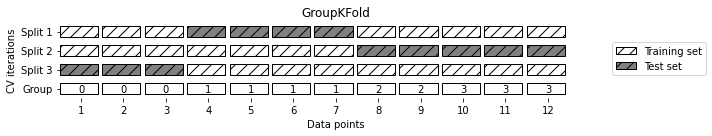

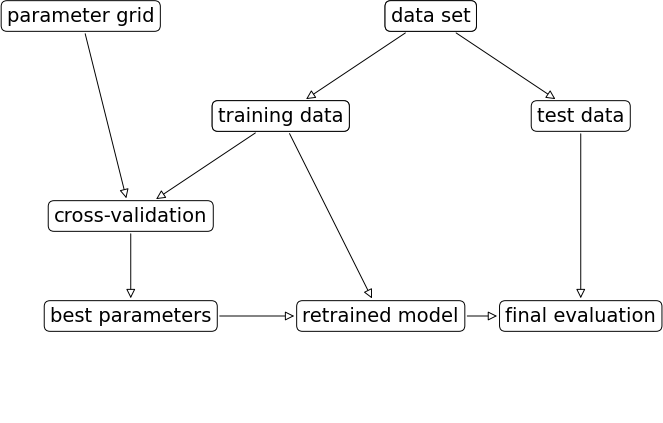

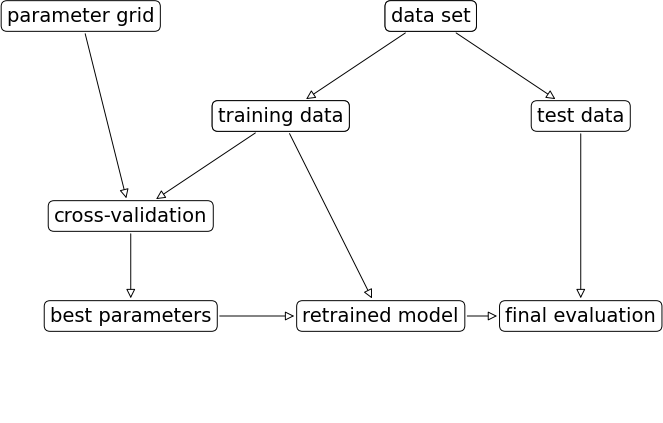

In [1]:
import matplotlib.pyplot as plt
from myst_nb import glue
from mglearn.plot_cross_validation import plot_group_kfold, plot_threefold_split
from mglearn.plot_grid_search import plot_grid_search_overview

# split plot
plot_threefold_split()
fig = plt.gcf()
glue("splitfig", fig, display=True)
plt.show() 

# kfold plot
plot_group_kfold()
fig = plt.gcf()
glue("kfoldfig", fig, display=True)
plt.show()

# gs overview plot
plot_grid_search_overview()
fig = plt.gcf()
glue("gsoverview", fig, display=True)
plt.show() 

(model_selection)=
# Model Selection
Model selection is the process of choosing among different candidate models. Model selection is often based on the evaluation metrics discussed in chapter [Model Evaluation](model_evaluation). In practice, however, there are typically many relevant other desiderata and requirements, such as robustness, interpretability, and the available resources.

## Estimating Performance
The goal of model selection is to select the model development procedure that results in the "best" model. An important (but not the only) consideration is to identify which approach results in the best predictive performance. Two common approaches to estimate the model's performance are splitting data and cross-validation.

### Splitting Data
The performance of a model on data that was used to fit the model is not a good estimate of the performance of the model on new, unseen data. For example, consider a model that simply repeats the labels of the instances it has previously seen. Such a model will be able to perfectly predict the instances in the training data, but performs terribly on unseen instances. More generally speaking, {term}`overfitting` occurs when the learned mapping relies on artefacts in the training data that do not generalize beyond the training data. At the other side of the spectrum, {term}`underfitting` occurs when the model class is not able to capture the underlying structure of the data. For example, a linear model will not be able to capture non-linear patterns in the data. In this case, the model will not perform well on neither the data it was trained on, nor new data.

To identify and prevent these issues, it is best practice to split your data in a training set, validation set, and test set.

```{glue:figure} splitfig
:name: "fig-split"

The dataset is split into a training set, validation set, and test set.[^mglearn]
```
* **{term}`Training set`.** This data (and this data alone!) is used to fit the machine learning model to.
* **{term}`Validation set`.** This set is used to estimate the performance of the trained model on unseen data. These performance estimates are used to select a model.
* **{term}`Test set`.** The performance estimate based on the validation set is influenced by randomness. In some cases, it will be lower than the actual generalization performance of the model, in other cases it is higher. **Because you choose the model that performs best on the validation set, validation set performance is likely to err on the optimistic side.** The test set serves as an estimate of how well the chosen model will perform on *new* data. To prevent a biased estimate, the test set should only be used once to estimate the performance of the final selected model.

Keep in mind that **any data pre-processing steps must solely be based on the training data**. Otherwise, information available only in the validation or test set may 'leak' into the model selection procedure. This can result in overly optimistic performance estimates. For example, when you normalize a feature or impute values based on the mean, the mean must be computed solely over the training data. Similarly, feature selection must be performed based on the information in the training set alone.

Depending on the learning task, the data may be split at random. If patterns within the data are likely to change over time, it may be more suitable to perform time-based splitting. For example, criminals often change tactics which means that patterns of fraud can change over time. In these situations, the oldest data is typically selected for training and the most recent data for testing. In this way, the performance estimates will best represent the performance in production.

In scikit-learn, we can use {func}`sklearn.model_selection.train_test_split` to split the data set.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# create synthethic data set
X, y = make_classification(random_state=0)

# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=1)
# further split into train and validation set
X_train, X_val, y_train, y_val = train_test_split(
  X_train, y_train, test_size=0.25, random_state=3)

# print 
print('train set shape: {}'.format(X_train.shape))
print('validation set shape: {}'.format(X_val.shape))
print('test set shape: {}'.format(X_test.shape))

train set shape: (60, 20)
validation set shape: (20, 20)
test set shape: (20, 20)


In the example above, the training set consists of 60 instances, the validation set of 20 instances, and the test set of 20 instances.

### Cross-validation
A disadvantage of splitting data is that you reduce the number of instances that can be used to train the model. Moreover, it may be the case that we are unlucky and, due to randomness, choose a validation set with relatively uncommon patterns. This can result in misleading performance estimates. A solution to this problem is cross-validation. In a {term}`k-fold cross-validation` procedure, the data set is split into $k$ folds (see {numref}`fig-kfold`). For each fold, a machine learning algorithm is tested on the current fold and trained on the remaining $k-1$ folds. The overall performance of the algorithm is then estimated based on the performance on all $k$ folds.

```{glue:figure} kfoldfig
:name: "fig-kfold"

A 3-fold cross validation. In each iteration, one of the three splits acts as the test set and the remaining splits act as the training set.[^mglearn]
```

In scikit-learn, we can use {class}`sklearn.model_selection.KFold` to define a cross validation procedure and we can use {func}`sklearn.model_selection.cross_val_score` to compute a metric output for each fold.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.2, random_state=1)

# define model
clf = LogisticRegression()

# define 3-fold cross validation procedure
kf = KFold(n_splits=3)

# compute performance for each fold
scores = cross_val_score(clf, X_train, y_train, cv=kf, scoring='accuracy')
print(scores)

[0.81481481 0.85185185 0.76923077]


From this exapmle, we can immediately see the value of the cross-validation procedure over merely splitting the data: the observed accuracy of the model varies a lot, depending on which fold is evaluated.

A cross-validation procedure can be repeated multiple times, in which the data is shuffled differently each time. This is referred to as {term}`repeated cross-validation` and is implemented in scikit-learn as {class}`sklearn.model_selection.RepeatedKFold`. It is also possible to use cross-validation for both the train-test split and the train-validation split. In this case, you require a {term}`nested cross-validation`. In the outer loop, the data set is split into folds used to determine the training/validation and test set. In the inner loop, the training/validation set of each test fold of the outer loop is further split into folds used for training and validation.

## Hyperparameter Tuning
During model selection, you may want to evaluate different machine learning algorithms. In addition, most modern machine learning algorithms have {term}`hyperparameter`s: parameters that control the learning process in some way. In many cases, the performance of a machine learning algorithm on a given learning task depends on these settings. The process of identifying the best settings for your learning task is referred to as {term}`hyperparameter tuning`.

Two common approaches for tuning hyperparameters are {term}`grid search` and {term}`random search`. For both approaches, the first step is to define the search space, i.e., the range of hyperparameter settings you would like to explore. Grid search consists of an exhaustive search over all hyperparameter settings in the search space. In a random search, on the other hand, hyperparameters are randomly sampled from the search space. A random search procedure is particularly useful when hyperparameters can take continuous values, such as the cost parameter of a support vector machine. In these cases, a random search procedure is known to outperform grid search (at least in theory).


```{glue:figure} gsoverview
:name: "fig-gsoverview"

An overview of the required components and steps of a grid search procedure.[^mglearn]
```

In scikit-learn, grid search and random search are implemented in {class}`sklearn.model_selection.GridSearchCV` and {class}`sklearn.model_selection.RandomizedSearchCV` respectively. Below you can find an example of a grid search over several values of the regularization parameter `C` of logistic regression, using a 3-fold cross validation.

In [4]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

# we want to try different values for the regularization parameter C
param_grid = {'C' : [0.001, 0.01, 0.1, 1]}
clf = LogisticRegression()
kf = KFold(n_splits=3)

# define grid search
gs = GridSearchCV( 
  estimator=clf,
  param_grid=param_grid,
  scoring=None, # use default scorer of LR (accuracy)
  refit=True,
  cv=kf,
)

# fit model
gs.fit(X_train, y_train)

# view cross-validation results
display(pd.DataFrame(gs.cv_results_)[['param_C', 'mean_test_score', 'std_test_score']])
print('best parameter: {}'.format(gs.best_params_))

# view test set result
print('test set accuracy: {:.2f}'.format(gs.score(X_test, y_test)))

,param_C,mean_test_score,std_test_score
0,0.001,0.597816,0.124481
1,0.01,0.734568,0.165865
2,0.1,0.799620,0.064185
3,1,0.811966,0.033790


best parameter: {'C': 1}
test set accuracy: 0.75


[^mglearn]: These figures were generated using the [`mglearn`](https://github.com/amueller/mglearn) package.